In [60]:
import networkx as nx
import csv

class Graph:
    def __init__(self):
        # Initialize an empty NetworkX graph
        self.G = nx.Graph()
        self.stream_paths = {}  # Dictionary to store paths for each stream
        self.queue_assignments = {}  # Dictionary to store queue assignments for each output port

    def load_from_csv(self, topology_file):
        """
        Loads a topology from a CSV file and populates the graph with nodes and edges.

        Args:
            topology_file (str): Path to the topology CSV file.
        """
        devices = []
        links = []

        # Use the csv module to read the file
        with open(topology_file, 'r') as file:
            reader = csv.reader(file)
            for fields in reader:
                if fields[0].lower() == 'es' or fields[0].lower() == 'sw':  # Device entry (SW or ES)
                    devices.append(fields)
                elif fields[0].lower() == 'link':  # Link entry
                    links.append(fields)

        # Add nodes (SW: Switch, ES: End System)
        for device in devices:
            device_type = device[0].strip()
            device_name = device[1].strip()
            self.G.add_node(device_name, type=device_type)

        # Add edges (LINK)
        for link in links:
            link_id = link[1].strip()
            source_device = link[2].strip()
            source_port = link[3].strip()
            destination_device = link[4].strip()
            destination_port = link[5].strip()
            
            # Add the edge (link) between source and destination devices
            self.G.add_edge(source_device, destination_device, link_id=link_id, source_port=source_port, destination_port=destination_port)

    def load_streams(self, streams_file):
        """
        Loads stream information from a CSV file.

        Args:
            streams_file (str): Path to the streams CSV file.
        """
        streams = []
        with open(streams_file, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                streams.append({
                    'pcp': int(row[0]),
                    'name': row[1].strip(),
                    'type': row[2].strip(),
                    'source': row[3].strip(),
                    'destination': row[4].strip(),
                    'size': int(row[5]),
                    'period': float(row[6]),
                    'deadline': float(row[7])
                })
        self.streams = streams

    def find_shortest_path(self, node_a, node_b):
        """
        Finds the shortest path between two nodes using Dijkstra's algorithm.

        Args:
            node_a (str): The source node.
            node_b (str): The destination node.

        Returns:
            path (list): The shortest path from node_a to node_b as a list of nodes.
        """
        try:
            # Verify that nodes exist in the graph
            if node_a not in self.G or node_b not in self.G:
                print(f"One or both of the nodes ({node_a}, {node_b}) are not in the graph.")
                return None
            
            # Use Dijkstra's algorithm to find the shortest path without weights
            path = nx.shortest_path(self.G, source=node_a, target=node_b)
            return path
        except nx.NetworkXNoPath:
            print(f"No path exists between {node_a} and {node_b}.")
            return None
        except nx.NodeNotFound:
            print(f"One or both of the nodes ({node_a}, {node_b}) are not in the graph.")
            return None

    def calculate_all_paths(self):
        """
        Calculates and stores the shortest paths for all streams.
        """
        for stream in self.streams:
            source = stream['source']
            destination = stream['destination']
            path = self.find_shortest_path(source, destination)
            if path:
                annotated_path = []
                for i in range(len(path) - 1):
                    current_node = path[i]
                    link_id = self.G.get_edge_data(current_node, path[i + 1])['link_id']
                    previous_node = path[i - 1] if i > 0 else 'N/A'
                    edge_data = self.G.get_edge_data(current_node, path[i + 1])
                    source_port = edge_data['source_port']
                    destination_port = edge_data['destination_port']
                    annotated_path.append(f"{current_node}:{link_id}:{source_port}:{stream['pcp']}")
                annotated_path.append(f"{path[-1]}:{destination_port}:{stream['pcp']}")
                self.stream_paths[stream['name']] = '->'.join(annotated_path)
                print(f"Stream {stream['name']} from {source} to {destination}: Annotated Path: {self.stream_paths[stream['name']]}")
            else:
                print(f"No path found for Stream {stream['name']} from {source} to {destination}")

    def assign_queues(self):
        """
        Assigns shaped queues for each combination of priority level and upstream source for every output port.
        """
        for stream_name, path in self.stream_paths.items():
            stream = next(s for s in self.streams if s['name'] == stream_name)
            pcp = stream['pcp']
            path_nodes = path.split('->')
            for i in range(len(path_nodes) - 1):
                current_node = path_nodes[i].split(':')[0]
                previous_node = path_nodes[i - 1].split(':')[0] if i > 0 else 'N/A'
                edge_data = self.G.get_edge_data(current_node, path_nodes[i + 1].split(':')[0])
                output_port = edge_data['destination_port']
                key = (current_node, previous_node, output_port, pcp)

                if key not in self.queue_assignments:
                    self.queue_assignments[key] = []
                self.queue_assignments[key].append(stream_name)
                print(f"Assigned Stream {stream_name} to Queue Key {key}")

    def compute_worst_case_delay(self, stream_name):
        """
        Computes the worst-case per-hop delay for a stream over its path.

        Args:
            stream_name (str): The name of the stream.

        Returns:
            float: The computed worst-case delay for the stream.
        """
        if stream_name not in self.stream_paths:
            print(f"No path found for stream {stream_name}.")
            return None

        path = self.stream_paths[stream_name].split('->')
        stream = next(s for s in self.streams if s['name'] == stream_name)
        b = stream['size'] + 42
        r = b / stream['period']
        l_hat = l_breve = stream['size'] + 42
        r_link = 1e9  # Assume 1 Gbps link rate for now

        total_delay = 0

        for i in range(len(path) - 1):
            current_node = path[i].split(':')[0]
            next_node = path[i + 1].split(':')[0]
            edge_data = self.G.get_edge_data(current_node, next_node)
            output_port = edge_data['destination_port']
            key = (current_node, path[i - 1].split(':')[0] if i > 0 else 'N/A', output_port, stream['pcp'])

            # Calculate r_H and b_H by considering higher priority streams at the current hop
            r_H = 0
            b_H = 0
            l_L = 0

            # Get streams sharing the same queue (Set I)
            same_priority_streams = self.queue_assignments.get(key, [])

            for other_stream_name in same_priority_streams:
                other_stream = next(s for s in self.streams if s['name'] == other_stream_name)
                if other_stream_name != stream_name:
                    l_L = max(l_L, other_stream['size'] + 42)

            # Consider higher priority streams and same priority streams at the output port
            for (node, prev_node, port, pcp), streams in self.queue_assignments.items():
                if node == current_node and port == output_port:
                    for interfering_stream_name in streams:
                        interfering_stream = next(s for s in self.streams if s['name'] == interfering_stream_name)
                        if pcp > stream['pcp'] or (pcp == stream['pcp'] and interfering_stream_name != stream_name):
                            r_H += interfering_stream['size'] / interfering_stream['period']
                            b_H += interfering_stream['size'] + 42

            # Calculate the worst-case per-hop delay using the updated formula
            try:
                per_hop_delay = (b_H + b + l_L) / (r_link - r_H) + (l_hat / r_link)
                total_delay += per_hop_delay
            except ZeroDivisionError:
                print(f"Division by zero error while calculating delay for stream {stream_name} at node {current_node}")
                return None

        return total_delay

# Example usage
topology_file = 'small-topology.csv'  # Replace with your actual file path
streams_file = 'small-streams.csv'  # Replace with your actual file path
graph = Graph()
graph.load_from_csv(topology_file)
graph.load_streams(streams_file)

# Print information about the graph
print(f"Graph has {graph.G.number_of_nodes()} nodes and {graph.G.number_of_edges()} edges.")

# Calculate all paths for the streams
graph.calculate_all_paths()

# Assign queues based on the Queue Assignment Rules
graph.assign_queues()

# Compute and print the worst-case delay for each stream
for stream in graph.streams:
    stream_name = stream['name']
    wcd = graph.compute_worst_case_delay(stream_name)
    if wcd is not None:
        print(f"Worst-case delay for Stream {stream_name}: {wcd:.2f} seconds")

Graph has 22 nodes and 24 edges.
Stream Flow_0 from node0_0_0_0 to node0_0_6_0: Annotated Path: node0_0_0_0:e3:2:0->sw_0_0:e1:0:0->sw_0_3:e6:2:0->sw_0_6:e21:3:0->node0_0_6_0:1:0
Stream Flow_1 from node0_0_4_1 to node0_0_3_1: Annotated Path: node0_0_4_1:e20:4:2->sw_0_4:e17:1:2->sw_0_6:e6:2:2->sw_0_3:e9:5:2->node0_0_3_1:1:2
Stream Flow_10 from node0_0_2_1 to node0_0_6_1: Annotated Path: node0_0_2_1:e24:3:1->sw_0_2:e5:1:1->sw_0_3:e6:2:1->sw_0_6:e22:4:1->node0_0_6_1:1:1
Stream Flow_11 from node0_0_5_1 to node0_0_6_0: Annotated Path: node0_0_5_1:e12:3:0->sw_0_5:e2:1:0->sw_0_0:e1:0:0->sw_0_3:e6:2:0->sw_0_6:e21:3:0->node0_0_6_0:1:0
Stream Flow_12 from node0_0_0_0 to node0_0_6_1: Annotated Path: node0_0_0_0:e3:2:0->sw_0_0:e1:0:0->sw_0_3:e6:2:0->sw_0_6:e22:4:0->node0_0_6_1:1:0
Stream Flow_13 from node0_0_4_1 to node0_0_6_0: Annotated Path: node0_0_4_1:e20:4:2->sw_0_4:e17:1:2->sw_0_6:e21:3:2->node0_0_6_0:1:2
Stream Flow_14 from node0_0_4_1 to node0_0_3_0: Annotated Path: node0_0_4_1:e20:4:1->sw_

In [ ]:
ref path solution:
Flow_0,38.529,12049,node0_0_0_0:e3:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e21:0->node0_0_6_0

Calculated sukution:
Flow_0,2.57,13396,node0_0_4_1:e20:4->sw_0_4:e17:1->sw_0_6:e6:2->sw_0_3:e9:5

In [ ]:

Flow_0,38.529,12049,node0_0_0_0:e3:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e21:0->node0_0_6_0
Flow_1,96.856,13396,node0_0_4_1:e20:2->sw_0_4:e17:2->sw_0_6:e6:2->sw_0_3:e9:2->node0_0_3_1
Flow_10,36.347,12910,node0_0_2_1:e24:1->sw_0_2:e5:1->sw_0_3:e6:1->sw_0_6:e22:1->node0_0_6_1
Flow_11,42.544,19044,node0_0_5_1:e12:0->sw_0_5:e2:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e21:0->node0_0_6_0
Flow_12,40.688,17020,node0_0_0_0:e3:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e22:0->node0_0_6_1
Flow_13,64.121,17088,node0_0_4_1:e20:2->sw_0_4:e17:2->sw_0_6:e21:2->node0_0_6_0
Flow_14,84.235,16154,node0_0_4_1:e20:1->sw_0_4:e17:1->sw_0_6:e6:1->sw_0_3:e8:1->node0_0_3_0

Graph has 22 nodes and 24 edges.
Finding path for Stream Flow_1 from node0_0_4_1 to node0_0_3_1
Stream Flow_1 from node0_0_4_1 to node0_0_3_1: Shortest Path: ['node0_0_4_1', 'sw_0_4', 'sw_0_6', 'sw_0_3', 'node0_0_3_1'], Worst-Case Delay: 2572.00 seconds
Finding path for Stream Flow_10 from node0_0_2_1 to node0_0_6_1
Stream Flow_10 from node0_0_2_1 to node0_0_6_1: Shortest Path: ['node0_0_2_1', 'sw_0_2', 'sw_0_3', 'sw_0_6', 'node0_0_6_1'], Worst-Case Delay: 3398.02 seconds
Finding path for Stream Flow_11 from node0_0_5_1 to node0_0_6_0
Stream Flow_11 from node0_0_5_1 to node0_0_6_0: Shortest Path: ['node0_0_5_1', 'sw_0_5', 'sw_0_0', 'sw_0_3', 'sw_0_6', 'node0_0_6_0'], Worst-Case Delay: 4168.64 seconds
Finding path for Stream Flow_12 from node0_0_0_0 to node0_0_6_1
Stream Flow_12 from node0_0_0_0 to node0_0_6_1: Shortest Path: ['node0_0_0_0', 'sw_0_0', 'sw_0_3', 'sw_0_6', 'node0_0_6_1'], Worst-Case Delay: 3261.00 seconds
Finding path for Stream Flow_13 from node0_0_4_1 to node0_0_6_0
Str

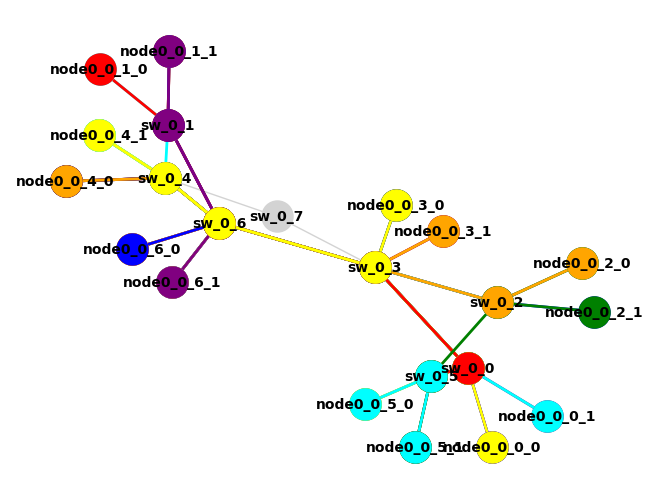

In [62]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import csv

class Graph:
    def __init__(self):
        # Initialize an empty NetworkX graph
        self.G = nx.Graph()

    def load_from_csv(self, topology_file):
        """
        Loads a topology from a CSV file and populates the graph with nodes and edges.

        Args:
            topology_file (str): Path to the topology CSV file.
        """
        devices = []
        links = []

        # Read the file line by line
        with open(topology_file, 'r') as file:
            for line in file:
                fields = line.strip().split(',')
                
                if fields[0] == 'SW' or fields[0] == 'ES':  # Device entry (SW or ES)
                    devices.append(fields)
                elif fields[0] == 'LINK':  # Link entry
                    links.append(fields)

        # Add nodes (SW: Switch, ES: End System)
        for device in devices:
            device_type = device[0]
            device_name = device[1].strip()
            self.G.add_node(device_name, type=device_type)

        # Add edges (LINK)
        for link in links:
            link_id = link[1].strip()
            source_device = link[2].strip()
            source_port = link[3].strip()
            destination_device = link[4].strip()
            destination_port = link[5].strip()
            
            # Add the edge (link) between source and destination devices
            self.G.add_edge(source_device, destination_device, link_id=link_id, source_port=source_port, destination_port=destination_port)

    def find_shortest_path(self, node_a, node_b):
        """
        Finds the shortest path between two nodes using Dijkstra's algorithm.

        Args:
            node_a (str): The source node.
            node_b (str): The destination node.

        Returns:
            path (list): The shortest path from node_a to node_b as a list of nodes.
        """
        try:
            # Verify that nodes exist in the graph
            if node_a not in self.G or node_b not in self.G:
                print(f"One or both of the nodes ({node_a}, {node_b}) are not in the graph.")
                return None
            
            # Use Dijkstra's algorithm to find the shortest path without weights
            path = nx.shortest_path(self.G, source=node_a, target=node_b)
            return path
        except nx.NetworkXNoPath:
            print(f"No path exists between {node_a} and {node_b}.")
            return None
        except nx.NodeNotFound:
            print(f"One or both of the nodes ({node_a}, {node_b}) are not in the graph.")
            return None

    def draw_graph(self):
        """
        Draws the entire graph.
        """
        pos = nx.spring_layout(self.G)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
        plt.show()

    def draw_paths(self, paths):
        """
        Draws the graph with multiple paths highlighted, each with a different color.

        Args:
            paths (list): A list of paths, where each path is a list of nodes.
        """
        if not isinstance(paths, list):
            print("Paths should be a list of paths (each path is a list of nodes).")
            return

        pos = nx.spring_layout(self.G)
        # Draw the full graph in light grey
        nx.draw(self.G, pos, with_labels=True, node_color='lightgrey', edge_color='lightgrey', node_size=500, font_size=10, font_weight='bold')

        # Colors for different paths
        colors = itertools.cycle(['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan'])

        # Iterate over each path in the paths list and color them differently
        for path in paths:
            if isinstance(path, list) and len(path) > 1:
                color = next(colors)
                path_edges = list(zip(path, path[1:]))  # Get the edges of the path
                nx.draw_networkx_nodes(self.G, pos, nodelist=path, node_color=color, node_size=500)
                nx.draw_networkx_edges(self.G, pos, edgelist=path_edges, edge_color=color, width=2)
            else:
                print(f"Invalid path: {path}")

        plt.show()

    def load_streams(self, streams_file):
        """
        Loads stream information from a CSV file.

        Args:
            streams_file (str): Path to the streams CSV file.
        """
        streams = []
        with open(streams_file, 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip the header
            for row in reader:
                streams.append({
                    'pcp': int(row[0]),
                    'name': row[1].strip(),
                    'type': row[2].strip(),
                    'source': row[3].strip(),
                    'destination': row[4].strip(),
                    'size': int(row[5]),
                    'period': float(row[6]),
                    'deadline': float(row[7])
                })
        self.streams = streams

    def compute_worst_case_delay(self, path, stream):
        """
        Computes the worst-case per-hop delay for a stream over a given path.

        Args:
            path (list): The path of nodes for the stream.
            stream (dict): Stream information including PCP, size, period, etc.

        Returns:
            float: The computed worst-case delay for the stream.
        """
        b = stream['size']
        r = b / stream['period']
        l_hat = l_breve = stream['size']
        r_link = 1  # Assume 1 Gbps link rate for now

        total_delay = 0

        for i in range(len(path) - 1):
            current_node = path[i]
            next_node = path[i + 1]
            edge_data = self.G.get_edge_data(current_node, next_node)
            output_port = edge_data['destination_port']

            # Calculate r_H and b_H by considering higher priority streams at the current hop
            r_H = 0
            b_H = 0
            l_L = 0

            for other_stream in self.streams:
                if other_stream['pcp'] > stream['pcp'] and other_stream['source'] == current_node:
                    r_H += other_stream['size'] / other_stream['period']
                    b_H += other_stream['size']
                elif other_stream['pcp'] == stream['pcp'] and other_stream['source'] == current_node and other_stream['name'] != stream['name']:
                    b_H += other_stream['size']
                elif other_stream['pcp'] < stream['pcp'] and other_stream['source'] == current_node:
                    l_L = max(l_L, other_stream['size'])

            # Calculate the worst-case per-hop delay using the updated formula
            try:
                per_hop_delay = max((b_H + b + l_L) / (r_link - r_H) + (l_hat / r_link), 0)
                total_delay += per_hop_delay
            except ZeroDivisionError:
                return float('inf')

        return total_delay

    def save_solution(self, solution_file):
        """
        Saves the computed paths and delays to a CSV file.

        Args:
            solution_file (str): Path to the solution CSV file.
        """
        with open(solution_file, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['StreamName', 'MaxE2E(us)', 'Deadline(us)', 'Path'])
            for idx, stream in enumerate(self.streams):
                source = stream['source']
                destination = stream['destination']
                path = self.find_shortest_path(source, destination)
                if path:
                    print(f"Stream {stream['name']}: Source: {source}, Destination: {destination}, Path: {path}")  # Debugging output
                    wcd = self.compute_worst_case_delay(path, stream) * 1e6  # Convert seconds to microseconds
                    formatted_path = '->'.join([
                        f"{node}:{self.G.get_edge_data(node, path[i + 1])['link_id']}:{self.G.get_edge_data(node, path[i + 1])['destination_port']}"
                        for i, node in enumerate(path[:-1])
                    ])
                    writer.writerow([f"Flow_{idx}", f"{wcd:.2f}", int(stream['deadline']), formatted_path])
                else:
                    print(f"No valid path found for Stream {stream['name']}: Source: {source}, Destination: {destination}")  # Debugging output
                    writer.writerow([f"Flow_{idx}", 'inf', int(stream['deadline']), 'No path'])

# Example usage
topology_file = 'small-topology.csv'  # Replace with your actual file path
streams_file = 'small-streams.csv'  # Replace with your actual file path
solution_file = 'small-solution_test.csv'  # Replace with your actual file path
graph = Graph()
graph.load_from_csv(topology_file)
graph.load_streams(streams_file)

# Print information about the graph
print(f"Graph has {graph.G.number_of_nodes()} nodes and {graph.G.number_of_edges()} edges.")

# Find and print the shortest paths between multiple pairs of nodes
for stream in graph.streams:
    source = stream['source']
    destination = stream['destination']
    print(f"Finding path for Stream {stream['name']} from {source} to {destination}")  # Debugging output
    path = graph.find_shortest_path(source, destination)
    if path:
        wcd = graph.compute_worst_case_delay(path, stream)
        print(f"Stream {stream['name']} from {source} to {destination}: Shortest Path: {path}, Worst-Case Delay: {wcd:.2f} seconds")
    else:
        print(f"No path found for Stream {stream['name']} from {source} to {destination}")

# Save the solution to a CSV file
graph.save_solution(solution_file)

# Draw multiple paths on the graph
paths = [graph.find_shortest_path(stream['source'], stream['destination']) for stream in graph.streams if graph.find_shortest_path(stream['source'], stream['destination'])]
graph.draw_paths(paths)

In [71]:
import networkx as nx
import csv

class Graph:
    def __init__(self):
        # Initialize an empty NetworkX graph
        self.G = nx.Graph()
        self.stream_paths = {}  # Dictionary to store paths for each stream
        self.queue_assignments = {}  # Dictionary to store queue assignments for each output port

    def load_from_csv(self, topology_file):
        """
        Loads a topology from a CSV file and populates the graph with nodes and edges.

        Args:
            topology_file (str): Path to the topology CSV file.
        """
        devices = []
        links = []

        # Use the csv module to read the file
        with open(topology_file, 'r') as file:
            reader = csv.reader(file)
            for fields in reader:
                if fields[0].lower() == 'es' or fields[0].lower() == 'sw':  # Device entry (SW or ES)
                    devices.append(fields)
                elif fields[0].lower() == 'link':  # Link entry
                    links.append(fields)

        # Add nodes (SW: Switch, ES: End System)
        for device in devices:
            device_type = device[0].strip()
            device_name = device[1].strip()
            self.G.add_node(device_name, type=device_type)

        # Add edges (LINK)
        for link in links:
            link_id = link[1].strip()
            source_device = link[2].strip()
            source_port = link[3].strip()
            destination_device = link[4].strip()
            destination_port = link[5].strip()
            
            # Add the edge (link) between source and destination devices
            self.G.add_edge(source_device, destination_device, link_id=link_id, source_port=source_port, destination_port=destination_port)

    def load_streams(self, streams_file):
        """
        Loads stream information from a CSV file.

        Args:
            streams_file (str): Path to the streams CSV file.
        """
        streams = []
        with open(streams_file, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                streams.append({
                    'pcp': int(row[0]),
                    'name': row[1].strip(),
                    'type': row[2].strip(),
                    'source': row[3].strip(),
                    'destination': row[4].strip(),
                    'size': int(row[5]),
                    'period': float(row[6]),
                    'deadline': float(row[7])
                })
        self.streams = streams

    def find_shortest_path(self, node_a, node_b):
        """
        Finds the shortest path between two nodes using Dijkstra's algorithm.

        Args:
            node_a (str): The source node.
            node_b (str): The destination node.

        Returns:
            path (list): The shortest path from node_a to node_b as a list of nodes.
        """
        try:
            # Verify that nodes exist in the graph
            if node_a not in self.G or node_b not in self.G:
                print(f"One or both of the nodes ({node_a}, {node_b}) are not in the graph.")
                return None
            
            # Use Dijkstra's algorithm to find the shortest path without weights
            path = nx.shortest_path(self.G, source=node_a, target=node_b)
            return path
        except nx.NetworkXNoPath:
            print(f"No path exists between {node_a} and {node_b}.")
            return None
        except nx.NodeNotFound:
            print(f"One or both of the nodes ({node_a}, {node_b}) are not in the graph.")
            return None

    def calculate_all_paths(self):
        """
        Calculates and stores the shortest paths for all streams.
        """
        for stream in self.streams:
            source = stream['source']
            destination = stream['destination']
            path = self.find_shortest_path(source, destination)
            if path:
                annotated_path = []
                for i in range(len(path) - 1):
                    current_node = path[i]
                    link_id = self.G.get_edge_data(current_node, path[i + 1])['link_id']
                    pcp = stream['pcp']
                    annotated_path.append(f"{current_node}:{link_id}:{pcp}")
                annotated_path.append(f"{path[-1]}:{pcp}")
                self.stream_paths[stream['name']] = '->'.join(annotated_path)
                print(f"Stream {stream['name']} from {source} to {destination}: Annotated Path: {self.stream_paths[stream['name']]}")
            else:
                print(f"No path found for Stream {stream['name']} from {source} to {destination}")

    def assign_queues(self):
        """
        Assigns shaped queues for each combination of priority level and upstream source for every output port.
        """
        for stream_name, path in self.stream_paths.items():
            stream = next(s for s in self.streams if s['name'] == stream_name)
            pcp = stream['pcp']
            path_nodes = path.split('->')
            for i in range(len(path_nodes) - 1):
                current_node = path_nodes[i].split(':')[0]
                previous_node = path_nodes[i - 1].split(':')[0] if i > 0 else 'N/A'
                key = (current_node, previous_node, pcp)

                if key not in self.queue_assignments:
                    self.queue_assignments[key] = []
                self.queue_assignments[key].append(stream_name)
                print(f"Assigned Stream {stream_name} to Queue Key {key}")

    def compute_worst_case_delay(self, stream_name):
        """
        Computes the worst-case per-hop delay for a stream over its path.

        Args:
            stream_name (str): The name of the stream.

        Returns:
            float: The computed worst-case delay for the stream.
        """
        if stream_name not in self.stream_paths:
            print(f"No path found for stream {stream_name}.")
            return None

        path = self.stream_paths[stream_name].split('->')
        stream = next(s for s in self.streams if s['name'] == stream_name)
        b = stream['size'] + 42
        r = b / stream['period']
        l_hat = l_breve = stream['size'] + 42
        r_link = 1e9  # Assume 1 Gbps link rate for now

        total_delay = 0

        for i in range(len(path) - 1):
            current_node = path[i].split(':')[0]
            previous_node = path[i - 1].split(':')[0] if i > 0 else 'N/A'
            key = (current_node, previous_node, stream['pcp'])

            # Calculate r_H and b_H by considering higher priority streams at the current hop
            r_H = 0
            b_H = 0
            l_L = 0

            # Get streams sharing the same queue (Set I)
            same_priority_streams = self.queue_assignments.get(key, [])

            for other_stream_name in same_priority_streams:
                other_stream = next(s for s in self.streams if s['name'] == other_stream_name)
                if other_stream_name != stream_name:
                    l_L = max(l_L, other_stream['size'] + 42)

            # Consider higher priority streams and same priority streams at the output port
            for (node, prev_node, pcp), streams in self.queue_assignments.items():
                if node == current_node and prev_node == previous_node:
                    for interfering_stream_name in streams:
                        interfering_stream = next(s for s in self.streams if s['name'] == interfering_stream_name)
                        if pcp > stream['pcp'] or (pcp == stream['pcp'] and interfering_stream_name != stream_name):
                            r_H += interfering_stream['size'] / interfering_stream['period']
                            b_H += interfering_stream['size'] + 42

            # Calculate the worst-case per-hop delay using the updated formula
            try:
                # Incorporate the committed transmission rate r into the available link rate
                available_rate = r_link - r_H
                if available_rate <= 0:
                    print(f"Error: Available rate is non-positive for stream {stream_name} at node {current_node}")
                    return None
                per_hop_delay = (b_H + b + l_L) / available_rate + (l_hat / r_link)
                total_delay += per_hop_delay
            except ZeroDivisionError:
                print(f"Division by zero error while calculating delay for stream {stream_name} at node {current_node}")
                return None

        return total_delay

# Example usage
topology_file = 'small-topology.csv'  # Replace with your actual file path
streams_file = 'small-streams.csv'  # Replace with your actual file path
graph = Graph()
graph.load_from_csv(topology_file)
graph.load_streams(streams_file)

# Print information about the graph
print(f"Graph has {graph.G.number_of_nodes()} nodes and {graph.G.number_of_edges()} edges.")

# Calculate all paths for the streams
graph.calculate_all_paths()

# Assign queues based on the Queue Assignment Rules
graph.assign_queues()

# Compute and print the worst-case delay for each stream
for stream in graph.streams:
    stream_name = stream['name']
    wcd = graph.compute_worst_case_delay(stream_name)
    if wcd is not None:
        print(f"Worst-case delay for Stream {stream_name}: {wcd:.7f} seconds")

Graph has 22 nodes and 24 edges.
Stream Flow_0 from node0_0_0_0 to node0_0_6_0: Annotated Path: node0_0_0_0:e3:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e21:0->node0_0_6_0:0
Stream Flow_1 from node0_0_4_1 to node0_0_3_1: Annotated Path: node0_0_4_1:e20:2->sw_0_4:e17:2->sw_0_6:e6:2->sw_0_3:e9:2->node0_0_3_1:2
Stream Flow_10 from node0_0_2_1 to node0_0_6_1: Annotated Path: node0_0_2_1:e24:1->sw_0_2:e5:1->sw_0_3:e6:1->sw_0_6:e22:1->node0_0_6_1:1
Stream Flow_11 from node0_0_5_1 to node0_0_6_0: Annotated Path: node0_0_5_1:e12:0->sw_0_5:e2:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e21:0->node0_0_6_0:0
Stream Flow_12 from node0_0_0_0 to node0_0_6_1: Annotated Path: node0_0_0_0:e3:0->sw_0_0:e1:0->sw_0_3:e6:0->sw_0_6:e22:0->node0_0_6_1:0
Stream Flow_13 from node0_0_4_1 to node0_0_6_0: Annotated Path: node0_0_4_1:e20:2->sw_0_4:e17:2->sw_0_6:e21:2->node0_0_6_0:2
Stream Flow_14 from node0_0_4_1 to node0_0_3_0: Annotated Path: node0_0_4_1:e20:1->sw_0_4:e17:1->sw_0_6:e6:1->sw_0_3:e8:1->node0_0_3_0:1
Stream Flow

In [ ]:
Flow_6,29.143,17690,node0_0_1_1:e16:2->sw_0_1:e14:2->sw_0_6:e22:2->node0_0_6_1
Flow_7,68.72,10302,node0_0_4_0:e19:0->sw_0_4:e17:0->sw_0_6:e6:0->sw_0_3:e5:0->sw_0_2:e23:0->node0_0_2_0
Flow_8,102.909,18993,node0_0_4_1:e20:2->sw_0_4:e17:2->sw_0_6:e6:2->sw_0_3:e8:2->node0_0_3_0
Flow_9,12.397,10860,node0_0_5_1:e12:1->sw_0_5:e11:1->node0_0_5_0